## Fit over correlation functions of knwon synthetic examples

In [1]:
import numpy as np
import xarray as xr
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import sstats.tseries as ts
from inspect import signature

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(28*1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:42203 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


### Exponential correlation :
$R_{xx} \propto e^{-\tau/T_L}$

In [2]:
def C_exp(t,Tb,a):
    return a*np.exp(-t/Tb)

In [3]:
DT = 500
nT = 30
Tl = 10
x = ts.exp_autocorr((DT, 1./24), np.full((nT,),Tl), 1, draws=100).rename('x').rename({'tau':'windows'}).persist()
x

<xarray.DataArray 'x' (windows: 30, draw: 100, time: 12000)>
dask.array<getitem, shape=(30, 100, 12000), dtype=float64, chunksize=(30, 25, 12000), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 10 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10 10
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
Attributes:
    rms:      1

### With or without detrending:

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


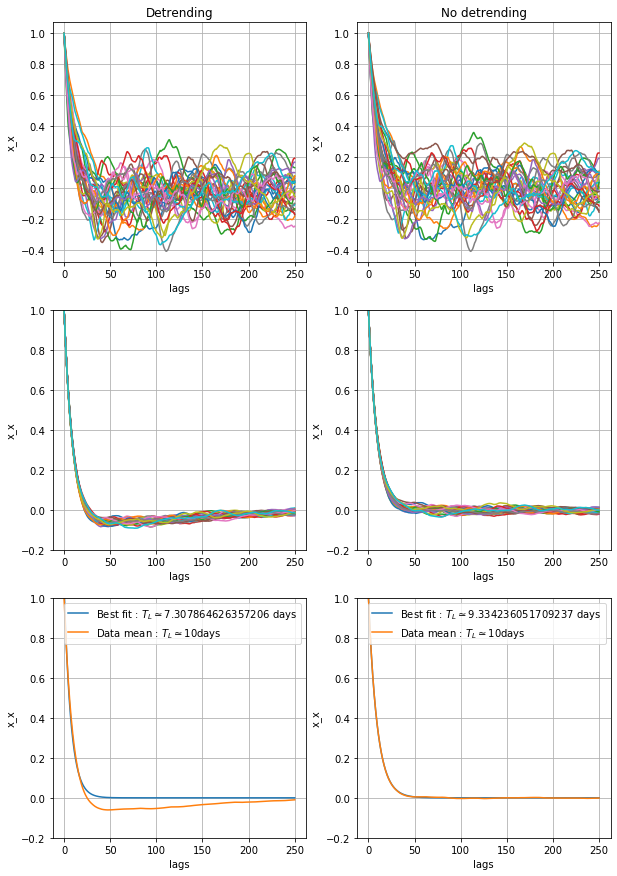

In [4]:
fig, axes = plt.subplots(3,2,figsize=(10,15))
for b,title,i in zip([True, False],['Detrending','No detrending'],range(2)):
    xx = ts.correlate(x,x,detrend=b).compute()
    _ = (xx/xx.sel(lags=0)).isel(draw=10).plot.line(ax=axes[0,i],x='lags',label='')
    axes[0,i].set_title(title);axes[0,i].legend().set_visible(False);axes[0,i].grid()
    _ = (xx/xx.sel(lags=0)).mean('draw').plot.line(ax=axes[1,i],x='lags',label='')
    axes[1,i].legend().set_visible(False);axes[1,i].set_ylim(-0.2,1);axes[1,i].grid()
    pa,co = scipy.optimize.curve_fit(C_exp,xx.lags,(xx/xx.sel(lags=0)).mean(['draw','windows']))
    C_exp(xx.lags,*[p for p in pa]).plot(ax=axes[2,i],x='lags',label=r'Best fit : $T_L\simeq$%s days'%pa[0])
    (xx/xx.sel(lags=0)).mean(['draw','windows']).plot(ax=axes[2,i],label='Data mean : $T_L\simeq$10days')
    axes[2,i].legend();axes[2,i].set_ylim(-0.2,1);axes[2,i].grid()
    

#### Comments : 
First line, All windows for one draw : We see the raw data prensent a strong variability (around the threshold, the values can go from -0.4 to 0.4 in the some windows).\
Second line (mean over draws for each window) : We see a negative lobe in the detrended case that is not observed in the second case. We can already expect a less acurate fit in the detrended case.\
Third line : Looking at the mean autocorrelation (over all draws and windows), we find a value very close of the true value, 10 days, with a relatiove error very small in the non detrended case.\ In the case where the signal was deternded, the estimation is not as accurate with a value of the decorrelation timescale around 7 days. This  is due to the negative loe created by the detrending. As it has been seen in our 'real' case, we expect this negative lobe to decrease when the total time window (DT) increases.Still it seems more accurate to use the non detrended time series.



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


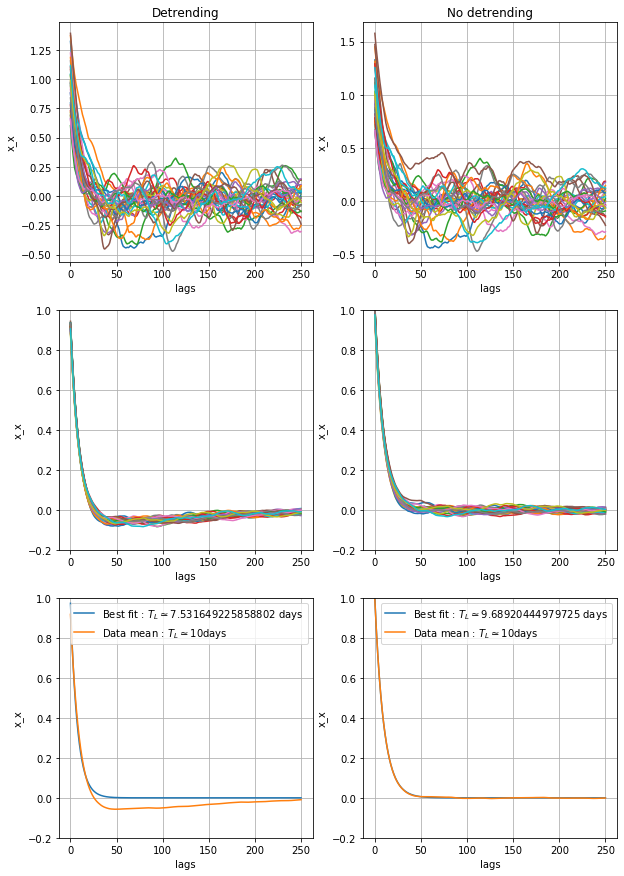

In [5]:
# Without normalization : 
fig, axes = plt.subplots(3,2,figsize=(10,15))
for b,title,i in zip([True, False],['Detrending','No detrending'],range(2)):
    xx = ts.correlate(x,x,detrend=b).compute()
    _ = xx.isel(draw=10).plot.line(ax=axes[0,i],x='lags',label='')
    axes[0,i].set_title(title);axes[0,i].legend().set_visible(False);axes[0,i].grid()
    _ = xx.mean('draw').plot.line(ax=axes[1,i],x='lags',label='')
    axes[1,i].legend().set_visible(False);axes[1,i].set_ylim(-0.2,1);axes[1,i].grid()
    pa,co = scipy.optimize.curve_fit(C_exp,xx.lags,xx.mean(['draw','windows']))
    C_exp(xx.lags,*[p for p in pa]).plot(ax=axes[2,i],x='lags',label=r'Best fit : $T_L\simeq$%s days'%pa[0])
    xx.mean(['draw','windows']).plot(ax=axes[2,i],label='Data mean : $T_L\simeq$10days')
    axes[2,i].legend();axes[2,i].set_ylim(-0.2,1);axes[2,i].grid()

#### Comments : 
Visually, no differences with the normalized case seem to be worthy of notice except the fact that the fit seems to be more accurate for both detrended and non detrended cases (for the mean).

### Fit mean over windows for each draw (no detrending) :

In [7]:
#xx = ts.correlate(x,x,detrend=False).compute()
sig = signature(C_exp)
pa,err = np.full((xx.draw.size,len(sig.parameters)-1),np.nan),np.full((xx.draw.size,len(sig.parameters)-1),np.nan)
for i in range(xx.draw.size):
    pa[i,:],co = scipy.optimize.curve_fit(C_exp,xx.lags,(xx/xx.sel(lags=0)).isel(draw=i).mean(['windows']))
    err[i,:] = np.abs(pa[i,:]-Tl)/Tl


Averaged over all draws and windows of the estimated $T_L$ : 9.400969970976439
Std of the estimated $T_L$ : 0.8150227927573092
Mean relative error : 8.332970107795655 percent


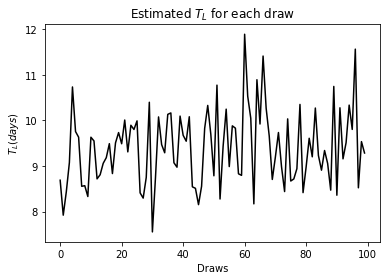

In [8]:
plt.plot(xx.draw,pa[:,0],'k');plt.title('Estimated $T_L$ for each draw')
plt.xlabel('Draws');plt.ylabel('$T_L (days)$')
print(r'Averaged over all draws and windows of the estimated $T_L$ : %s' %pa[:,0].mean())
print(r'Std of the estimated $T_L$ : %s' %pa[:,0].std())
print('Mean relative error : %s percent'% (err[:,0].mean()*1e2))

#### Comments :
We find a mean estimate of TL close to 10 days, with a relative error around 7%

In [9]:
#Non noramilzed : 
pa,err = np.full((xx.draw.size,len(sig.parameters)-1),np.nan),np.full((xx.draw.size,len(sig.parameters)-1),np.nan)
for i in range(xx.draw.size):
    pa[i,:],co = scipy.optimize.curve_fit(C_exp,xx.lags,xx.isel(draw=i).mean(['windows']))
    err[i,:] = np.abs(pa[i,:]-Tl)/Tl


Averaged over all draws and windows of the estimated $T_L$ : 9.76312568547402
Std of the estimated $T_L$ : 0.941028035454587
Mean relative error : 7.948538301819368 percent


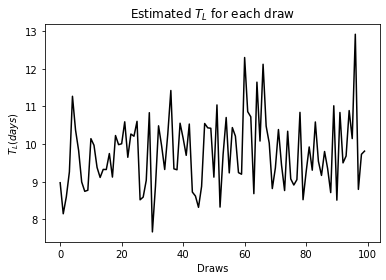

In [10]:
plt.plot(xx.draw,pa[:,0],'k');plt.title('Estimated $T_L$ for each draw')
plt.xlabel('Draws');plt.ylabel('$T_L (days)$')
print(r'Averaged over all draws and windows of the estimated $T_L$ : %s' %pa[:,0].mean())
print(r'Std of the estimated $T_L$ : %s' %pa[:,0].std())
print('Mean relative error : %s percent'% (err[:,0].mean()*1e2))

#### comments :
We find a better mean estimation

### Varying the time window size (DT) and the number of windows (nT) : 
We want to study the sensibilty of our fit to the time series we use and the number of segments. Knowing that in our 'real' case of study the more we have time segments, the less our time window is large.

In [11]:
def param_fit(x,myfunc,DT,nT,Tl,n,X = 'normalized',detrend=False):
    """Generate n samples using ts.exp_autocorr 
    and find the best fit for each sample and the relative error to the true value Tl 
    """
    sig = signature(myfunc)
    xx = ts.correlate(x.sel(time=slice(100,DT+100)).isel(windows=slice(0,nT),draw=slice(0,n)),
                      x.sel(time=slice(100,DT+100)).isel(windows=slice(0,nT),draw=slice(0,n)),detrend=detrend).persist()
    if X=='normalized':
        xx = xx/xx.sel(lags=0) 
    else :
        pass
    pa,err = np.full((xx.draw.size,len(sig.parameters)-1),np.nan),np.full((xx.draw.size,len(sig.parameters)-1),np.nan)
    true_val=[Tl]
    for i in range(xx.draw.size):
        pa[i,:],co = scipy.optimize.curve_fit(myfunc,xx.lags,xx.isel(draw=i).mean(['windows']))
        err[i,:] = np.abs(pa[i,:]-true_val)/true_val
    
    out = xr.Dataset({'params':(['draws','param'],pa),
                      'errors':(['draws','param'],err)},
                     coords={"draws":np.arange(0,n,1),'param':[V for V in sig.parameters.keys()][1:]})
#    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [12]:
DT = np.arange(20,350,50)#[40,80,100,200]
nT = np.arange(1,30,5)#[2,5,10,20,30]
out = xr.combine_nested([[param_fit(x,C_exp,T,nt,Tl,100)for T in DT] for nt in nT],concat_dim=['Nw','Tw'])
out['Nw'] = nT
out['Tw'] = DT

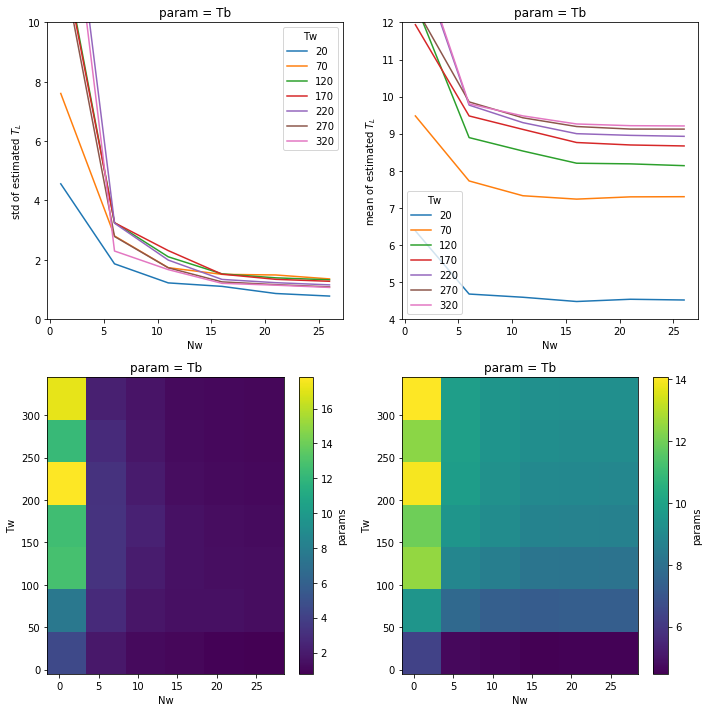

In [13]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out['params'].sel(param='Tb').std('draws').plot.line(ax=axes[0,0],x='Nw');axes[0,0].set_ylabel(r'std of estimated $T_L$')
out['params'].sel(param='Tb').mean('draws').plot.line(ax=axes[0,1],x='Nw');axes[0,1].set_ylabel(r'mean of estimated $T_L$')
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,12)
out['params'].sel(param='Tb').std('draws').plot(ax=axes[1,0])
out['params'].sel(param='Tb').mean('draws').plot(ax=axes[1,1])
fig.tight_layout()

#### Comments : 
General comment :  For small values of Nw (2 and 7) the values of the std and mean seem very noisy. 

Std of the estmated decorrelation timescale (first colmun) : For larger numbers the std seems to reach a threshold (Nw$\geq12$). We don't observe large differences in the std depending on Tw, all thresholds seeming to remain between 1 and 2 with the exception of Tw=20days for which the std is smaller and closer to 1.

Mean of the estmated decorrelation timescale (Second column) : As expected, the larger the window size is, the better the estimation seems to be. For each time window size, the mean does not vary a lot for number of segments superior to $\sim$12. The mean seem to stabilize around values superior to 9 days for T$\geq$170days

In [14]:
DT = np.arange(20,350,50)#[40,80,100,200]
nT = np.arange(1,30,5)#[2,5,10,20,30]
out_nonorm= xr.combine_nested([[param_fit(x,C_exp,T,nt,Tl,100,X='')for T in DT] for nt in nT],concat_dim=['Nw','Tw'])
out_nonorm['Nw'] = nT
out_nonorm['Tw'] = DT

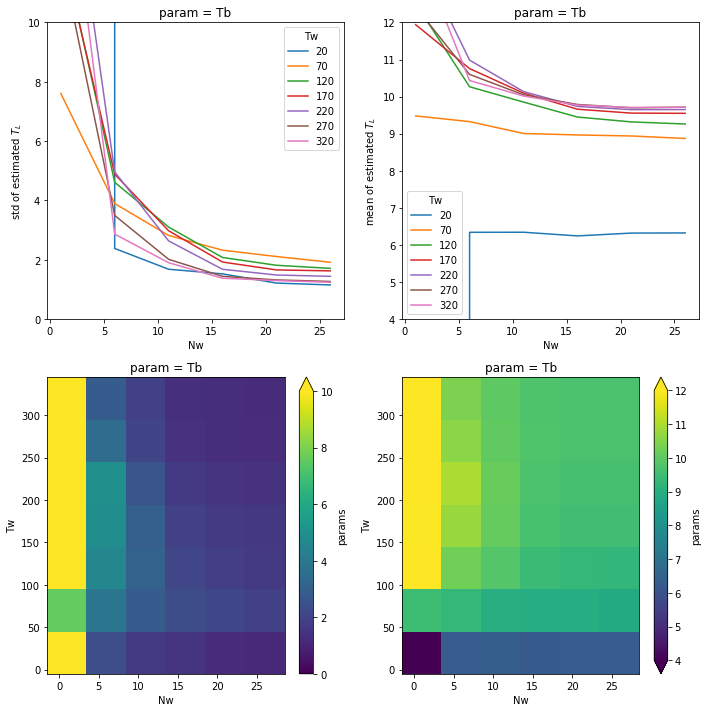

In [16]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out_nonorm['params'].sel(param='Tb').std('draws').plot.line(ax=axes[0,0],x='Nw');
axes[0,0].set_ylabel(r'std of estimated $T_L$')
out_nonorm['params'].sel(param='Tb').mean('draws').plot.line(ax=axes[0,1],x='Nw');
axes[0,1].set_ylabel(r'mean of estimated $T_L$')
out_nonorm['params'].sel(param='Tb').std('draws').plot(ax=axes[1,0],vmin=0,vmax=10)
out_nonorm['params'].sel(param='Tb').mean('draws').plot(ax=axes[1,1],vmin=4,vmax=12)
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,12)
fig.tight_layout()

### Comments : 
For both normalized and non normalized autocorrelation, the mean value of the estimated decorrelation timescale is far from the true value (10 days).\
In the non normalized case the std is larger for all time windows size and number and we find more diffreneces from a window size to another, threshold decresing for Tw from 70 to 320days. Tw=20days has also smaller std than the other window sizes but a mean estimation around 6.5days.

The mean estimated Tl closer from one another for all Tw other than 20 days. We find $T_L^*\geq$9 days for Tw$\geq$120days

### Fit for each windows :


In [45]:
def param_fit2(x,myfunc,DT,nT,Tl,n,X = 'normalized',detrend=False):
    """Generate n samples using ts.exp_autocorr 
    and find the best fit for each sample and the relative error to the true value Tl 
    """
    sig = signature(myfunc)
    xx = ts.correlate(x.sel(time=slice(100,DT+100)).isel(windows=slice(0,nT),draw=slice(0,n)),
                      x.sel(time=slice(100,DT+100)).isel(windows=slice(0,nT),draw=slice(0,n)),detrend=detrend).persist()
    if X=='normalized':
        xx = xx/xx.sel(lags=0) 
    else :
        pass
    pa = np.full((xx.draw.size,xx.windows.size,len(sig.parameters)-1),np.nan)
    err = np.full((xx.draw.size,xx.windows.size,len(sig.parameters)-1),np.nan)
    true_val=[Tl]
    for i in range(xx.draw.size):
        for j in range(xx.windows.size):
            try:
                pa[i,j,:],co = scipy.optimize.curve_fit(myfunc,xx.lags,xx.isel(draw=i,windows=j))
                err[i,j,:] = np.abs(pa[i,j,:]-true_val)/true_val
            except:
                pass
            
    
    out = xr.Dataset({'params':(['draw','param'],pa.mean(axis=1)),
                      'errors':(['draw','param'],err.mean(axis=1))},
                     coords={"draws":np.arange(0,n,1),'param':[V for V in sig.parameters.keys()][1:]})
#    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [31]:
scipy.optimize.curve_fit(C_exp,xx.lags,xx.isel(draw=1,windows=10))

(array([5.81848286, 0.61845069]),
 array([[ 1.39997872e-02, -7.38820444e-04],
        [-7.38820444e-04,  7.85430740e-05]]))

In [46]:
 out2 = xr.combine_nested([[param_fit2(x,C_exp,T,nt,Tl,100)for T in [10,20]] for nt in [2,5]],concat_dim=['Nw','Tw'])

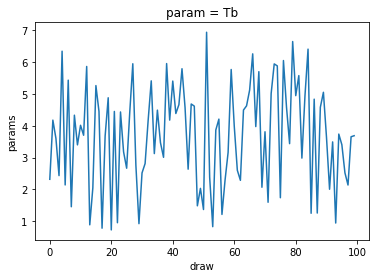

In [52]:
out2['params'].sel(param='Tb').isel(Tw=0,Nw=0).plot()

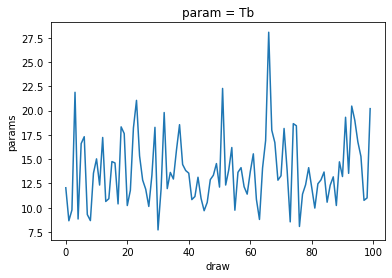

In [23]:
out2['params'].mean('windows').sel(param='Tb').plot()

In [53]:
out2= xr.combine_nested([[param_fit2(x,C_exp,T,nt,Tl,100)for T in DT] for nt in nT],concat_dim=['Nw','Tw'])
out2['Nw'] = nT
out2['Tw'] = DT

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/xarray

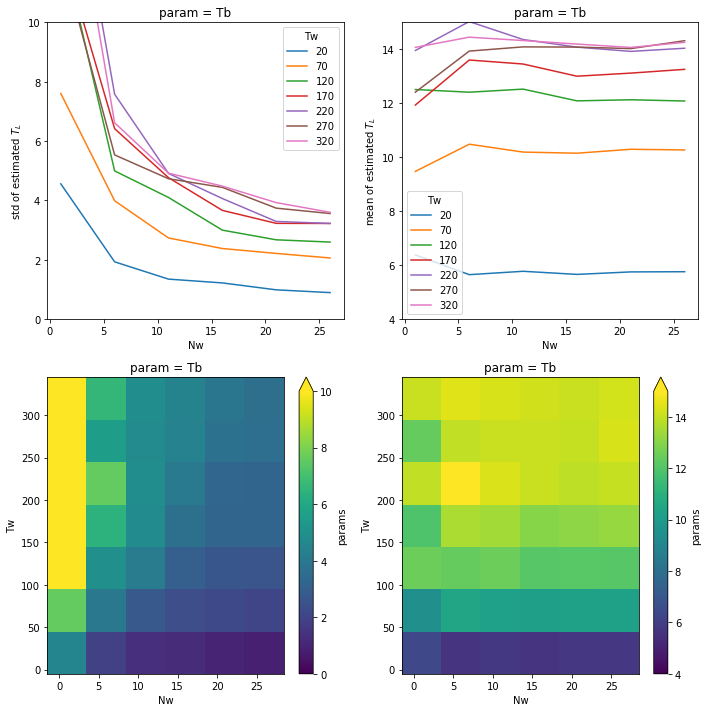

In [62]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out2['params'].sel(param='Tb').std('draw').plot.line(ax=axes[0,0],x='Nw',hue='Tw');
axes[0,0].set_ylabel(r'std of estimated $T_L$')
out2['params'].sel(param='Tb').mean('draw').plot.line(ax=axes[0,1],x='Nw',hue='Tw');
axes[0,1].set_ylabel(r'mean of estimated $T_L$')
out2['params'].sel(param='Tb').std('draw').plot(ax=axes[1,0],vmin=0,vmax=10)
out2['params'].sel(param='Tb').mean('draw').plot(ax=axes[1,1],vmin=4,vmax=15)
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,15)
fig.tight_layout()

### Oscillatory process (internal tides):
$x = a(t) cos(\omega t)$\
$R_{xx} = \frac{R_a}{2} cos(\omega \windows)$ where $R_a=e^{-\tau/T_L}$

In [4]:
def C_per(t,Tl):
    return np.exp(-t/Tl)/2*np.cos(2*np.pi*2*t)

In [5]:
DT = 50
nT = 10
n = 100
Tl = 7
x = ts.exp_autocorr((DT, 1./24), np.full((nT,),Tl), 1, draws=n).rename('x')
X = (x*np.cos(2*np.pi*2*x.time)).rename('X')
X

<xarray.DataArray 'X' (tau: 10, draw: 100, time: 1200)>
dask.array<mul, shape=(10, 100, 1200), dtype=float64, chunksize=(10, 100, 1200), chunktype=numpy.ndarray>
Coordinates:
  * tau      (tau) int64 7 7 7 7 7 7 7 7 7 7
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 49.88 49.92 49.96

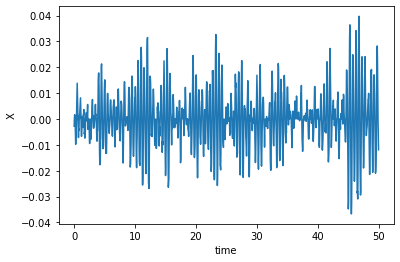

In [6]:
X.mean(['draw','tau']).plot()

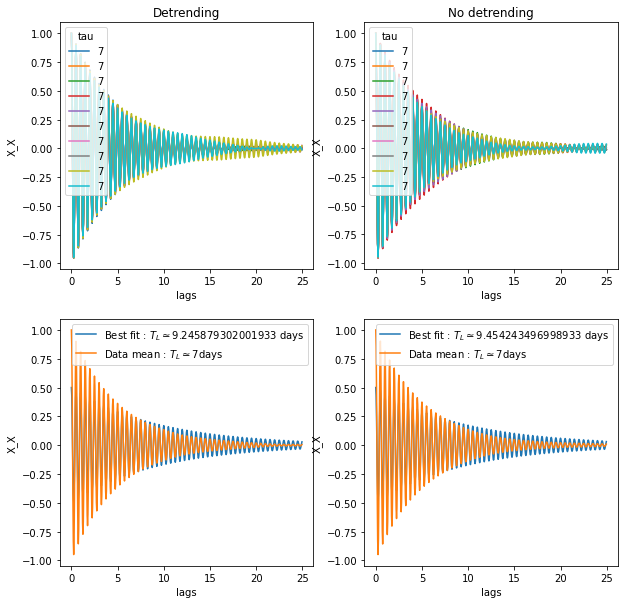

In [7]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
for b,title,i in zip([True, False],['Detrending','No detrending'],range(2)):
    xx = ts.correlate(X,X,detrend=b).persist()
    _ = (xx/xx.sel(lags=0)).mean('draw').plot.line(ax=axes[0,i],x='lags')
    axes[0,i].set_title(title)
    pa,co = scipy.optimize.curve_fit(C_per,xx.lags,(xx/xx.sel(lags=0)).mean(['draw','tau']))
    C_per(xx.lags,*[p for p in pa]).plot(ax=axes[1,i],x='lags',label=r'Best fit : $T_L\simeq$%s days'%pa[0])
    (xx/xx.sel(lags=0)).mean(['draw','tau']).plot(ax=axes[1,i],label='Data mean : $T_L\simeq$7days')
    axes[1,i].legend()

#### Comments : 
Interestingly we pbserve in some "segments" a node. It would mean that the node we observe in our data has no physical explaination but is an artifact of the correlation function we applied ??

In [12]:
xx = ts.correlate(X,X,detrend=False).persist()
pa,err = np.full((xx.draw.size),np.nan),np.full(xx.draw.size,np.nan)
for i in range(xx.draw.size):
    pa[i],co = scipy.optimize.curve_fit(C_per,xx.lags,(xx/xx.sel(lags=0)).isel(draw=i).mean(['tau']))
    err[i] = np.abs(pa[i]-Tl)/Tl



Averaged over all draws and windows of the estimated $T_L$ : 9.485842932378283
Std of the estimated $T_L$ : 2.878946490237734
Mean relative error : 41.976844310389865 percent


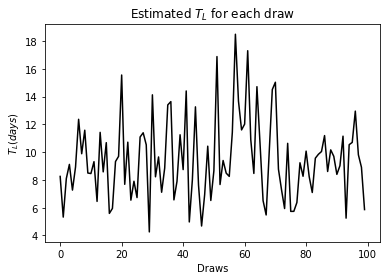

In [13]:
plt.plot(xx.draw,pa,'k');plt.title('Estimated $T_L$ for each draw')
plt.xlabel('Draws');plt.ylabel('$T_L (days)$')
print(r'Averaged over all draws and windows of the estimated $T_L$ : %s' %pa.mean())
print(r'Std of the estimated $T_L$ : %s' %pa.std())
print('Mean relative error : %s percent'% (err.mean()*1e2))

#### Comments : 
The decorrelation timescale is overestimated in the case of a exponentially decaying oscillation. This might be due to the decrease of the amplitude of oscillations leading a least squares that are more easily minimized for larger values of $\tau$. This could be corrected by applying uncertainties increasing with $\tau$ and/or taking smaller time windows.

In [14]:
xx = ts.correlate(X.sel(time=slice(0,20)),X.sel(time=slice(0,20)),detrend=False).persist()
pa,err = np.full((xx.draw.size),np.nan),np.full(xx.draw.size,np.nan)
for i in range(xx.draw.size):
    pa[i],co = scipy.optimize.curve_fit(C_per,xx.lags,(xx/xx.sel(lags=0)).isel(draw=i).mean(['tau']))
    err[i] = np.abs(pa[i]-Tl)/Tl

Averaged over all draws and windows of the estimated $T_L$ : 7.724407073932331
Std of the estimated $T_L$ : 2.7793049333475803
Mean relative error : 31.332417355759333 percent


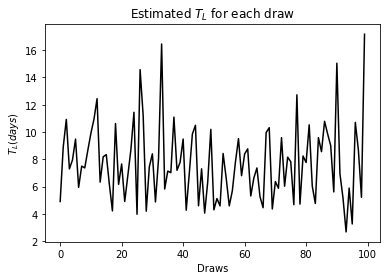

In [15]:
plt.plot(xx.draw,pa,'k');plt.title('Estimated $T_L$ for each draw')
plt.xlabel('Draws');plt.ylabel('$T_L (days)$')
print(r'Averaged over all draws and windows of the estimated $T_L$ : %s' %pa.mean())
print(r'Std of the estimated $T_L$ : %s' %pa.std())
print('Mean relative error : %s percent'% (err.mean()*1e2))

### Comments : 
We obtain a better estimation of the decorrelation timescale : $T_L\simeq 7.7$ vs $T_L\simeq9.5$ 

In [10]:
cluster.close()